In [1]:
import pandas as pd
import os

PATH = "C:/Users/Ato/Documents/Programming/Python/Titanic/data/"
train_path = PATH + "train.csv"
test_path = os.path.join(PATH,"test.csv")

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)


- We are going to use the classes with the highest pearson coeficients computed in the other notebook. **Pclass**, **Fare**, **Sex** and **Cabin**.

In [2]:
drop_features_train = ['Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Embarked']
drop_features_test = ['Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Embarked']

train['Sex'] = train['Sex'].apply(lambda x: 0 if x == 'male' else 1)
train['Cabin'] = train['Cabin'].fillna(0).apply(lambda x: 1 if x != 0 else 0)

test['Sex'] = test['Sex'].apply(lambda x: 0 if x == 'male' else 1)
test['Cabin'] = test['Cabin'].fillna(0).apply(lambda x: 1 if x != 0 else 0)

y = train['Survived'].copy()
X = train.drop(columns=drop_features_train).copy()

X_test = test.drop(columns=drop_features_test).copy()

- Dividing training and validation sets

In [3]:
from sklearn.model_selection import train_test_split

# Splitting the data into train and test
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.9, random_state=42)  
X_train.shape, X_val.shape

((801, 5), (90, 5))

- Hyperparameter tunning with GridSearchCV

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

from sklearn.model_selection import GridSearchCV

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [14]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 180 candidates, totalling 720 fits


KeyboardInterrupt: 

In [ ]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=30,
                       n_jobs=-1, random_state=42)

- Model definition with tunned hyperparameters

In [5]:


model = RandomForestClassifier(random_state=42, n_jobs=1, max_depth = 10, n_estimators=30, min_samples_leaf=5, oob_score=True)

In [6]:
%%time
model.fit(X_train, y_train)

CPU times: total: 31.2 ms
Wall time: 89.9 ms


RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=30,
                       n_jobs=1, oob_score=True, random_state=42)

- Results

In [7]:
model.oob_score_

0.7940074906367042

In [8]:
y_val_pred = model.predict(X_val)
print(f'Model: {model}')

Model: RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=30,
                       n_jobs=1, oob_score=True, random_state=42)


In [9]:
X_val.head()

,PassengerId,Pclass,Sex,Fare,Cabin
709,710,3,0,15.2458,0
439,440,2,0,10.5000,0
840,841,3,0,7.9250,0
720,721,2,1,33.0000,0
39,40,3,1,11.2417,0


In [10]:
from sklearn.metrics import classification_report, confusion_matrix

conf_matrix = confusion_matrix(y_val, y_val_pred)
report = classification_report(y_val, y_val_pred)

print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))

Confusion Matrix:
 [[46  8]
 [ 7 29]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86        54
           1       0.78      0.81      0.79        36

    accuracy                           0.83        90
   macro avg       0.83      0.83      0.83        90
weighted avg       0.83      0.83      0.83        90



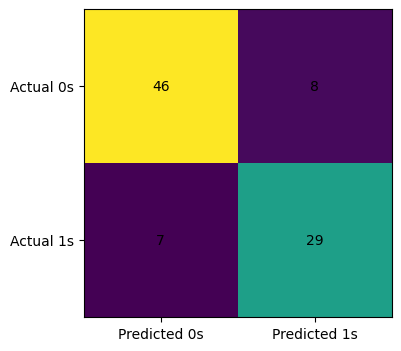

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(conf_matrix)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, conf_matrix[i, j], ha='center', va='center', color='black')
plt.show()

- Building dataset for Kaggle

In [33]:
y_pred = model.predict(X_test)

In [80]:
dataset_kaggle_dict = {'PassengerId': test['PassengerId'].copy(),'Survived':y_pred}
dataset_kaggle_df = pd.DataFrame(dataset_kaggle_dict)
dataset_kaggle_df.to_csv('C:/Users/Ato/Documents/Programming/Python/Titanic/predictions/RF.csv', index=False)

#### Save the model with Joblib

To save a sklearn model there are several methods that could be used. Among them, cPickle and Joblib are the most used ones and here we choose Joblib due to being optimized for numerical data, being faster (specially with large numpy arrays or complex objects) and handling memory-mapped files efficiently.

While it is true that for this small dataset both methods would work fine, for future works is better to familiarize with more scalable methods such as Joblib.

In [12]:
import joblib

joblib.dump(model, "../models/rf79.joblib")

['../models/rf79.joblib']

- Upload testing

In [13]:
model_test = joblib.load("../models/rf79.joblib")

In [14]:
model_test.predict(X_val)

array([0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0], dtype=int64)

In [15]:
import numpy as np

# Generate random values for the features
passengerId = np.random.choice([0,900])
sex = np.random.choice([0, 1])  # 0 or 1 for binary class (assuming 0 for one class and 1 for the other)
cabin = np.random.choice([0, 1])  # 0 or 1 for binary class
pclass = np.random.choice([1, 2, 3])  # 1, 2, or 3
fare = np.random.uniform(0, 100)  # Random float between 0 and 100

# Create a NumPy array with the values
test_sample = np.array([[passengerId, pclass, sex, fare, cabin]])

print("Test Sample:")
print(test_sample)


Test Sample:
[[0.         2.         1.         8.11777005 1.        ]]


In [16]:
model_test.predict(test_sample)

c:\Users\Ato\Documents\Programming\Python\Titanic\.env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([1], dtype=int64)

In [20]:
model_test.predict_proba(test_sample)

c:\Users\Ato\Documents\Programming\Python\Titanic\.env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[0.28085033, 0.71914967]])